In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [17]:
MAIN_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/Pickle_files_1851/'

In [23]:
sorter_path = os.path.join(MAIN_PATH, 'Sorter_ID1851_N0_DIV100_DATE20240530_1342_spontaneous_.raw.h5/wf_folder_curated/')
wf_path = os.path.join(sorter_path, 'waveforms/')
unit_pre = 9
unit_post = 8
unit_id = unit_post

In [24]:
unit_locations = np.load(os.path.join(sorter_path, 'unit_locations/unit_locations.npy'))

In [25]:
#unit_locations

In [26]:
wf = np.load(os.path.join(wf_path, f'waveforms_{unit_id}.npy'))

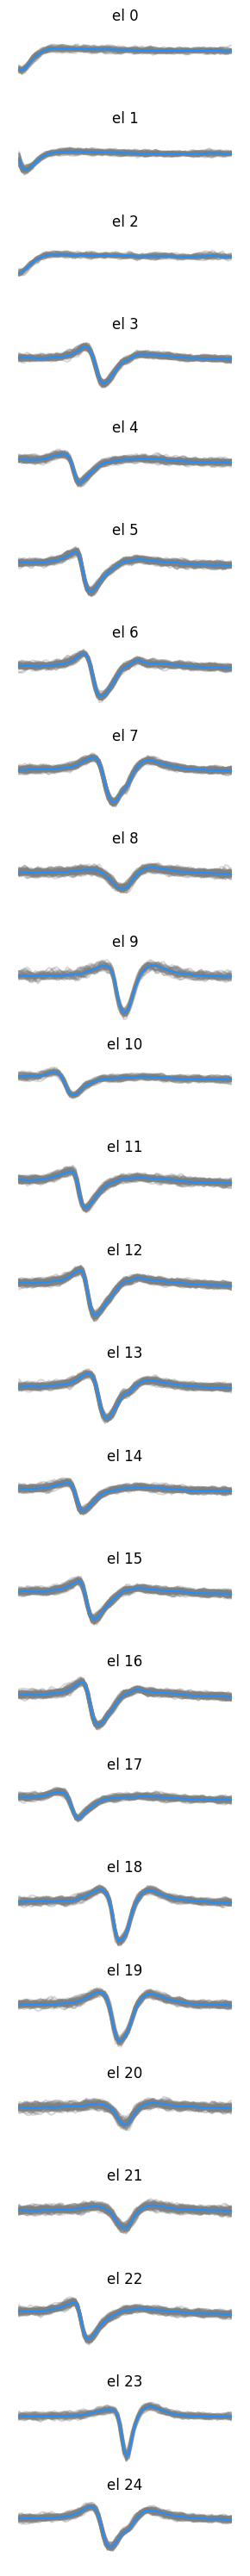

In [30]:
fig, axs = plt.subplots(25, 1, figsize=(3, 30), sharex=True, sharey=True)
for el in range(25):  # Plot first 10 electrodes
    # Plot individual traces in gray
    for trace in wf[:, :, el]:  # Use el directly since we want first 10
        mean_trace = np.mean(wf[:, :, el], axis=0)
        std_trace = np.std(wf[:, :, el], axis=0)
        if np.all(np.abs(trace - mean_trace) <= 2 * std_trace):
            axs[el].plot(trace, color='grey', alpha=0.3)
    
    # Plot mean trace in red
    axs[el].plot(np.mean(wf[:, :, el], axis=0), color='dodgerblue')
    axs[el].set_title(f'el {el}')
    #axs[el].set_ylim(-250, 250)  # Set y-limits based on your data range
for ax in axs:
    ax.axis('off')
plt.subplots_adjust(hspace=0)
plt.tight_layout()
plt.savefig(os.path.join(MAIN_PATH, f'Results/waveforms_{unit_id}.png'), dpi=300)
plt.savefig(os.path.join(MAIN_PATH, f'Results/waveforms_{unit_id}.pdf'), dpi=300)
plt.show()

In [31]:
templates = np.load(os.path.join(MAIN_PATH, 'templates_average.npy'))

In [12]:
templates.shape

(45, 80, 815)

In [13]:
filename = 'ID1851_N0_DIV100_DATE20240530_1342_spontaneous_.raw.h5'
recording_path = f"/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Nono/Raw_Data/2024_05_30_Synaptic_Blockers/spont/spontaneous/{filename}"
sorting_path = f"/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/Nonos_synaptic_blockers/Sorters/Sorter_{filename}/"

In [8]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json
import seaborn as sns
sys.path.append('/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/')
#from src.utils.logger_functions import console
from src.cmos_plotter.Plotter_Helper_KV import *
from src.utils.metadata_functions import load_metadata_as_dataframe
from src.utils.logger_functions import console
from src.cmos_plotter import Conduction_speed_plotter as csp
import spikeinterface.extractors as se
import pickle


/usr/itetnas04/data-scratch-01/kvulic/data/conda_envs/old_sorter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-20 21:35:01,588 Registering codec 'zlib'
2025-02-20 21:35:01,589 Registering codec 'gzip'
2025-02-20 21:35:01,590 Registering codec 'bz2'
2025-02-20 21:35:01,591 Registering codec 'lzma'
2025-02-20 21:35:01,595 Registering codec 'blosc'
2025-02-20 21:35:01,596 Registering codec 'zstd'
2025-02-20 21:35:01,597 Registering codec 'lz4'
2025-02-20 21:35:01,600 Registering codec 'astype'
2025-02-20 21:35:01,601 Registering codec 'delta'
2025-02-20 21:35:01,602 Registering codec 'quantize'
2025-02-20 21:35:01,603 Registering codec 'fixedscaleoffset'
2025-02-20 21:35:01,604 Registering codec 'packbits'
2025-02-20 21:35:01,605 Registering codec 'categorize'
2025-02-20 21:35:01,606 Registering 

In [9]:
CHIP_ID = 1297
DIV = 28
MAIN_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/Ferrans_processed_data_heart'
RECORDING_PATH = f'/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Ferran/1_Recordings/{CHIP_ID}_HeartShape/{CHIP_ID}_DIV{DIV}_HeartShape'
#SORTER_PATH = os.path.join(MAIN_PATH, 'Sorters/')
SORTER_PATH = f'/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Ferran/2_Processed_Data/{CHIP_ID}_HeartShape/{CHIP_ID}_DIV{DIV}_HeartShape'
CONDUCTION_SPEEDS_PATH = os.path.join(MAIN_PATH, f'Conduction_speeds/{CHIP_ID}/DIV{DIV}')
if not os.path.exists(CONDUCTION_SPEEDS_PATH):
    os.makedirs(CONDUCTION_SPEEDS_PATH)
filenames = os.listdir(SORTER_PATH)
#filenames = [f for f in filenames if '1352' in f or '1342' in f]
filenames = [f for f in filenames if 'Sorter' in f]

a= 0
for idx, filename in enumerate(filenames):
    filename = filename[7:]

    
    if os.path.exists(os.path.join(CONDUCTION_SPEEDS_PATH, f'{filename}_conduction_speeds.pkl')):
        console.info(f'Conduction speeds already calculated for {filename}. Skipping...')
        continue
    try:
    #if a == 0:
        print('Calculating conduction speeds for:', filename)
        recording = se.MaxwellRecordingExtractor(os.path.join(RECORDING_PATH, f'{filename}'))
        #print(recording)

        template_path = os.path.join(SORTER_PATH, f'Sorter_{filename}/wf_folder_curated/')

        #sorting = si.load_extractor(os.path.join(sorting_path,'sorter_output'))
        # Get sampling rate
        sampling_rate = recording.get_sampling_frequency()

        # Get probe locations
        probe_locations = recording.get_channel_locations()

        # Extract templates
        templates = csp.load_and_extract_templates(template_path)

        # Analyze conduction speeds
        results = csp.analyze_conduction_speeds(templates, probe_locations, sampling_rate)

        for result in results:
            result['speed'] = result['speed'] / 1000  # Convert to m/s
        
        with open(os.path.join(CONDUCTION_SPEEDS_PATH, f'{filename}_conduction_speeds.pkl'), 'wb') as f:
            pickle.dump(results, f)

        #generate resuls_combine that stacks all results
        if idx == 0:
            results_combined = results
        else:
            results_combined = results_combined + results
    except Exception as e:
        console.info(f'Could not calculate conduction speeds for {filename} due to the following error: {e}')
        continue

with open(os.path.join(CONDUCTION_SPEEDS_PATH, f'combined_conduction_speeds_ID{CHIP_ID}_DIV{DIV}.pkl'), 'wb') as f:
    pickle.dump(results_combined, f)
print("Done!")

    
    

2025-02-20 21:35:02,143 Could not calculate conduction speeds for ID1297_N4_DIV28_DATE20241213_1203_spontaneous_.raw.h5 due to the following error: [Errno 2] No such file or directory: '/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Ferran/2_Processed_Data/1297_HeartShape/1297_DIV28_HeartShape/Sorter_ID1297_N4_DIV28_DATE20241213_1203_spontaneous_.raw.h5/wf_folder_curated/templates_average.npy'


Calculating conduction speeds for: ID1297_N4_DIV28_DATE20241213_1203_spontaneous_.raw.h5
Calculating conduction speeds for: ID1297_N3_DIV28_DATE20241213_1203_spontaneous_.raw.h5


2025-02-20 21:35:02,319 Could not calculate conduction speeds for ID1297_N3_DIV28_DATE20241213_1203_spontaneous_.raw.h5 due to the following error: [Errno 2] No such file or directory: '/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Ferran/2_Processed_Data/1297_HeartShape/1297_DIV28_HeartShape/Sorter_ID1297_N3_DIV28_DATE20241213_1203_spontaneous_.raw.h5/wf_folder_curated/templates_average.npy'
2025-02-20 21:35:02,566 Could not calculate conduction speeds for ID1297_N9_DIV28_DATE20241213_1203_spontaneous_.raw.h5 due to the following error: [Errno 2] No such file or directory: '/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Ferran/2_Processed_Data/1297_HeartShape/1297_DIV28_HeartShape/Sorter_ID1297_N9_DIV28_DATE20241213_1203_spontaneous_.raw.h5/wf_folder_curated/templates_average.npy'


Calculating conduction speeds for: ID1297_N9_DIV28_DATE20241213_1203_spontaneous_.raw.h5
Calculating conduction speeds for: ID1297_N8_DIV28_DATE20241213_1203_spontaneous_.raw.h5


2025-02-20 21:35:02,710 Could not calculate conduction speeds for ID1297_N8_DIV28_DATE20241213_1203_spontaneous_.raw.h5 due to the following error: [Errno 2] No such file or directory: '/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Ferran/2_Processed_Data/1297_HeartShape/1297_DIV28_HeartShape/Sorter_ID1297_N8_DIV28_DATE20241213_1203_spontaneous_.raw.h5/wf_folder_curated/templates_average.npy'
2025-02-20 21:35:02,837 Could not calculate conduction speeds for ID1297_N7_DIV28_DATE20241213_1203_spontaneous_.raw.h5 due to the following error: [Errno 2] No such file or directory: '/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Ferran/2_Processed_Data/1297_HeartShape/1297_DIV28_HeartShape/Sorter_ID1297_N7_DIV28_DATE20241213_1203_spontaneous_.raw.h5/wf_folder_curated/templates_average.npy'


Calculating conduction speeds for: ID1297_N7_DIV28_DATE20241213_1203_spontaneous_.raw.h5
Calculating conduction speeds for: ID1297_N5_DIV28_DATE20241213_1203_spontaneous_.raw.h5


2025-02-20 21:35:02,936 Could not calculate conduction speeds for ID1297_N5_DIV28_DATE20241213_1203_spontaneous_.raw.h5 due to the following error: [Errno 2] No such file or directory: '/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Ferran/2_Processed_Data/1297_HeartShape/1297_DIV28_HeartShape/Sorter_ID1297_N5_DIV28_DATE20241213_1203_spontaneous_.raw.h5/wf_folder_curated/templates_average.npy'
2025-02-20 21:35:03,080 Could not calculate conduction speeds for ID1297_N6_DIV28_DATE20241213_1203_spontaneous_.raw.h5 due to the following error: [Errno 2] No such file or directory: '/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Ferran/2_Processed_Data/1297_HeartShape/1297_DIV28_HeartShape/Sorter_ID1297_N6_DIV28_DATE20241213_1203_spontaneous_.raw.h5/wf_folder_curated/templates_average.npy'


Calculating conduction speeds for: ID1297_N6_DIV28_DATE20241213_1203_spontaneous_.raw.h5
Calculating conduction speeds for: ID1297_N0_DIV28_DATE20241213_1203_spontaneous_.raw.h5


2025-02-20 21:35:03,207 Could not calculate conduction speeds for ID1297_N0_DIV28_DATE20241213_1203_spontaneous_.raw.h5 due to the following error: [Errno 2] No such file or directory: '/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Ferran/2_Processed_Data/1297_HeartShape/1297_DIV28_HeartShape/Sorter_ID1297_N0_DIV28_DATE20241213_1203_spontaneous_.raw.h5/wf_folder_curated/templates_average.npy'
2025-02-20 21:35:03,306 Could not calculate conduction speeds for ID1297_N10_DIV28_DATE20241213_1203_spontaneous_.raw.h5 due to the following error: [Errno 2] No such file or directory: '/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Ferran/2_Processed_Data/1297_HeartShape/1297_DIV28_HeartShape/Sorter_ID1297_N10_DIV28_DATE20241213_1203_spontaneous_.raw.h5/wf_folder_curated/templates_average.npy'


Calculating conduction speeds for: ID1297_N10_DIV28_DATE20241213_1203_spontaneous_.raw.h5
Calculating conduction speeds for: ID1297_N2_DIV28_DATE20241213_1203_spontaneous_.raw.h5


2025-02-20 21:35:03,434 Could not calculate conduction speeds for ID1297_N2_DIV28_DATE20241213_1203_spontaneous_.raw.h5 due to the following error: [Errno 2] No such file or directory: '/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Ferran/2_Processed_Data/1297_HeartShape/1297_DIV28_HeartShape/Sorter_ID1297_N2_DIV28_DATE20241213_1203_spontaneous_.raw.h5/wf_folder_curated/templates_average.npy'
2025-02-20 21:35:03,543 Could not calculate conduction speeds for ID1297_N1_DIV28_DATE20241213_1203_spontaneous_.raw.h5 due to the following error: [Errno 2] No such file or directory: '/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Ferran/2_Processed_Data/1297_HeartShape/1297_DIV28_HeartShape/Sorter_ID1297_N1_DIV28_DATE20241213_1203_spontaneous_.raw.h5/wf_folder_curated/templates_average.npy'


Calculating conduction speeds for: ID1297_N1_DIV28_DATE20241213_1203_spontaneous_.raw.h5


NameError: name 'results_combined' is not defined

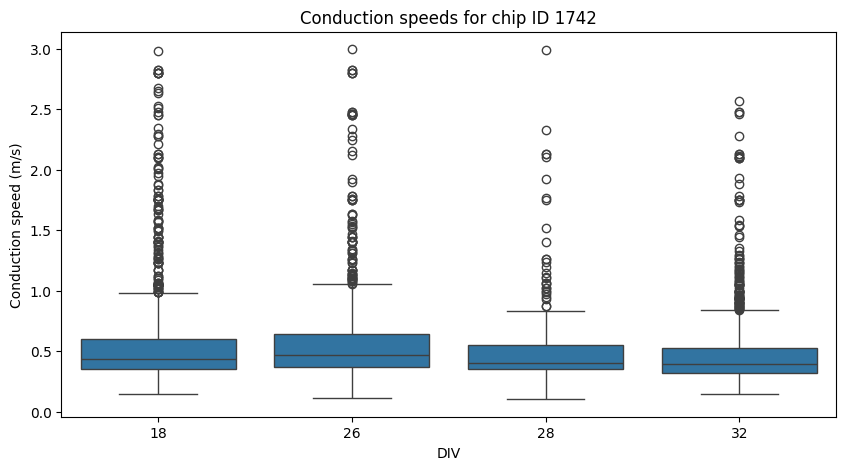

T-test results:
DIV18 vs DIV26: TtestResult(statistic=-0.708763550802074, pvalue=0.47855095328945985, df=2072.0)
DIV26 vs DIV28: TtestResult(statistic=2.5607640237721374, pvalue=0.010566733005597037, df=1190.0)
DIV28 vs DIV32: TtestResult(statistic=2.067589777621464, pvalue=0.03885902583836949, df=1423.0)
DIV18 vs DIV32: TtestResult(statistic=6.490698182838051, pvalue=1.0426767097049043e-10, df=2305.0)
DIV18 vs DIV28: TtestResult(statistic=2.023810065152449, pvalue=0.04317508887229103, df=1432.0)
DIV26 vs DIV32: TtestResult(statistic=7.267755657550035, pvalue=5.160800718033831e-13, df=2063.0)


In [9]:
#load combined_conduction_speeds_ID{CHIP_ID}_DIV{DIV}.pkl for on chip id for all divs and plot the conduction speeds vs div as violin plots
#load combined_conduction_speeds_ID{CHIP_ID}_DIV{DIV}.pkl for on chip id for all divs and plot the conduction speeds vs div as violin plots
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
MAIN_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/Ferrans_processed_data_heart'

CHIP_ID = 1742
DIVS = [18,26,28,32]
all_speeds = []
all_divs = []

for div in DIVS:
    try:
        CONDUCTION_SPEEDS_PATH = os.path.join(MAIN_PATH, f'Conduction_speeds/{CHIP_ID}/DIV{div}')
        with open(os.path.join(CONDUCTION_SPEEDS_PATH, f'combined_conduction_speeds_ID{CHIP_ID}_DIV{div}.pkl'), 'rb') as f:
            results = pickle.load(f)
        speeds = [result['speed'] for result in results if result['speed'] < 3]
        divs = [div for result in results if result['speed'] < 3]
        all_speeds.extend(speeds)
        all_divs.extend(divs)
    except:
        pass

df = pd.DataFrame({'speed': all_speeds, 'div': all_divs})
fig, ax = plt.subplots(figsize=(10, 5))
#sns.violinplot(data=df, x='div', y='speed', ax=ax)
#plot as boxplot
sns.boxplot(data=df, x='div', y='speed', ax=ax)
ax.set_title(f'Conduction speeds for chip ID {CHIP_ID}')
ax.set_xlabel('DIV')
ax.set_ylabel('Conduction speed (m/s)')
plt.show()
#do a significance test
from scipy.stats import ttest_ind
div18 = df[df['div'] == 18]['speed']
div26 = df[df['div'] == 26]['speed']
div28 = df[df['div'] == 28]['speed']
div32 = df[df['div'] == 32]['speed']
ttest_ind(div18, div26)
ttest_ind(div26, div28)
ttest_ind(div28, div32)
ttest_ind(div18, div32)
ttest_ind(div18, div28)
ttest_ind(div26, div32)

#print t-test results
print('T-test results:')
print('DIV18 vs DIV26:', ttest_ind(div18, div26))
print('DIV26 vs DIV28:', ttest_ind(div26, div28))
print('DIV28 vs DIV32:', ttest_ind(div28, div32))
print('DIV18 vs DIV32:', ttest_ind(div18, div32))
print('DIV18 vs DIV28:', ttest_ind(div18, div28))
print('DIV26 vs DIV32:', ttest_ind(div26, div32))


In [5]:
import spikeinterface.widgets as sw

2025-02-20 20:36:23,679 bytecode dump:
>          0	NOP(arg=None, lineno=326)
           2	LOAD_FAST(arg=1, lineno=328)
           4	LOAD_FAST(arg=2, lineno=328)
           6	BINARY_FLOOR_DIVIDE(arg=None, lineno=328)
           8	STORE_FAST(arg=3, lineno=328)
          10	LOAD_CONST(arg=1, lineno=329)
          12	LOAD_FAST(arg=3, lineno=329)
          14	BINARY_MULTIPLY(arg=None, lineno=329)
          16	STORE_FAST(arg=4, lineno=329)
          18	LOAD_GLOBAL(arg=0, lineno=331)
          20	LOAD_ATTR(arg=1, lineno=331)
          22	LOAD_FAST(arg=4, lineno=331)
          24	LOAD_GLOBAL(arg=0, lineno=331)
          26	LOAD_ATTR(arg=2, lineno=331)
          28	LOAD_CONST(arg=2, lineno=331)
          30	CALL_FUNCTION_KW(arg=2, lineno=331)
          32	STORE_FAST(arg=5, lineno=331)
          34	LOAD_GLOBAL(arg=3, lineno=333)
          36	LOAD_GLOBAL(arg=4, lineno=333)
          38	LOAD_FAST(arg=0, lineno=333)
          40	CALL_FUNCTION(arg=1, lineno=333)
          42	CALL_FUNCTION(arg=1, li

2025-02-18 10:49:34,785 findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.0.
2025-02-18 10:49:34,786 findfont: score(FontEntry(fname='/usr/itetnas04/data-scratch-01/kvulic/data/conda_envs/old_sorter/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-02-18 10:49:34,786 findfont: score(FontEntry(fname='/usr/itetnas04/data-scratch-01/kvulic/data/conda_envs/old_sorter/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-02-18 10:49:34,786 findfont: score(FontEntry(fname='/usr/itetnas04/data-scratch-01/kvulic/data/conda_envs/old_sorter/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', varian

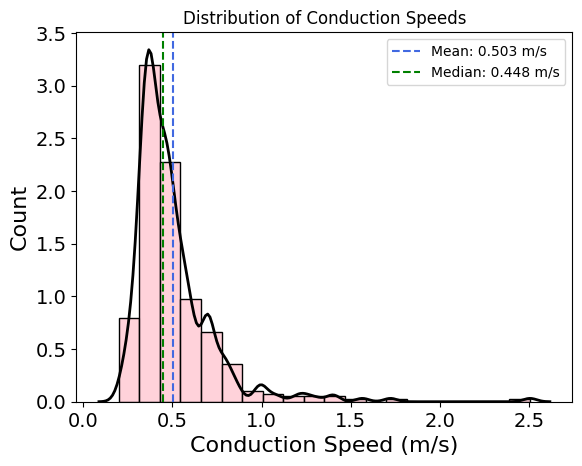

In [16]:
sns.histplot([r['speed'] for r in results_combined], bins=20, color='pink', alpha=0.7, edgecolor='black', stat='density')
# Add distribution as a line plot
sns.kdeplot([r['speed'] for r in results_combined], color='black', linewidth=2, bw_adjust = 0.5)
# Add mean and median lines
mean_speed = np.mean([r['speed'] for r in results_combined])
median_speed = np.median([r['speed'] for r in results_combined])
std_speed = np.std([r['speed'] for r in results])
plt.axvline(mean_speed, color= 'royalblue', linestyle='--', label=f'Mean: {mean_speed:.3f} m/s')
plt.axvline(median_speed, color='green', linestyle='--', label=f'Median: {median_speed:.3f} m/s')

plt.legend()
plt.xlabel('Conduction Speed (m/s)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Count', fontsize=16)
plt.title('Distribution of Conduction Speeds')
plt.savefig(os.path.join(MAIN_PATH, 'Conduction_speeds/combined_conduction_speeds.png'))
plt.savefig(os.path.join(MAIN_PATH, 'Conduction_speeds/combined_conduction_speeds.pdf'), dpi=300)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_spatial_waveforms(wf_folder, unit_id, probe_locations, sampling_rate=20000):
    """
    Plot waveforms arranged by electrode position
    
    Parameters:
    -----------
    wf_folder : str
        Path to the wf_folder_curated/waveforms directory
    unit_id : int
        Unit ID to plot
    probe_locations : array
        Array of shape (n_channels, 2) with electrode x,y positions
    sampling_rate : int
        Sampling rate in Hz for time axis
    """
    # Load waveforms for this unit
    waveforms = np.load(f'{wf_folder}/waveforms_{unit_id}.npy')
    
    # Calculate time axis in ms
    time = np.arange(waveforms.shape[1]) / sampling_rate * 1000
    #print(time)
    
    # Get unique x and y positions
    x_positions = np.unique(probe_locations[:, 0])
    y_positions = np.unique(probe_locations[:, 1])
    n_rows = len(y_positions)
    n_cols = len(x_positions)
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    fig.suptitle(f'Unit {unit_id} Waveforms', fontsize=16)
    
    # Calculate scale for consistent y-axis across all subplots
    y_min = np.min(waveforms)
    y_max = np.max(waveforms)
    y_range = y_max - y_min
    y_lim = (y_min - 0.1*y_range, y_max + 0.1*y_range)
    
    # Plot each electrode
    for i, x in enumerate(x_positions):
        for j, y in enumerate(y_positions[::-1]):  # Reverse y to match MEA layout
            ax = axes[j, i]
            
            # Find the electrode at this position
            electrode_idx = np.where((probe_locations[:, 0] == x) & 
                                   (probe_locations[:, 1] == y))[0]
            
            if len(electrode_idx) > 0:
                electrode_idx = electrode_idx[0]
                # Plot individual waveforms in gray
                ax.plot(time, waveforms[:, :, electrode_idx], 
                       color='gray', alpha=0.2)
                
                # Plot mean waveform in blue
                ax.plot(time, np.mean(waveforms[:, :, electrode_idx], axis=0), 
                       color='blue', linewidth=2)
                
                # Add channel number
                ax.text(0.02, 0.98, f'Ch {electrode_idx}', 
                       transform=ax.transAxes, 
                       verticalalignment='top',
                       fontsize=10)
            
            # Set consistent y-limits and remove ticks for cleaner look
            ax.set_ylim(y_lim)
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Only add axis labels for edge plots
            if i == 0 and j == n_rows-1:
                ax.set_xlabel('Time (ms)')
                ax.set_ylabel('Amplitude')
    
    plt.tight_layout()
    return fig, axes

In [18]:
filenames


['Sorter_ID1851_N0_DIV100_DATE20240530_1352_spontaneous_.raw.h5',
 'Sorter_ID1851_N4_DIV100_DATE20240530_1342_spontaneous_.raw.h5',
 'Sorter_ID1851_N2_DIV100_DATE20240530_1352_spontaneous_.raw.h5',
 'Sorter_ID1851_N2_DIV100_DATE20240530_1342_spontaneous_.raw.h5',
 'Sorter_ID1851_N3_DIV100_DATE20240530_1352_spontaneous_.raw.h5',
 'Sorter_ID1851_N0_DIV100_DATE20240530_1342_spontaneous_.raw.h5',
 'Sorter_ID1851_N1_DIV100_DATE20240530_1342_spontaneous_.raw.h5',
 'Sorter_ID1851_N4_DIV100_DATE20240530_1352_spontaneous_.raw.h5',
 'Sorter_ID1851_N1_DIV100_DATE20240530_1352_spontaneous_.raw.h5',
 'Sorter_ID1851_N3_DIV100_DATE20240530_1342_spontaneous_.raw.h5']

In [19]:
wf_path = os.path.join(SORTER_PATH, f'Sorter_{filename}/wf_folder_curated/waveforms')
unit_id = 0  # The unit you want to plot
probe_locations = recording.get_channel_locations()

fig, axes = plot_spatial_waveforms(wf_path, unit_id, probe_locations)
plt.show()

IndexError: index 404 is out of bounds for axis 2 with size 25